# Function

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title='Confusion matrix'):
    fig = plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='2d', cmap='Blues')#, normalize='true')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title, fontsize=20)
    plt.rcParams.update({'font.size': 18})
    plt.show()

def get_metrics(df,title):
    df = df.copy().dropna(subset=['labels'])

    y_true = df['labels']
    y_pred = df['pred']

    conf_matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'F1 score: {f1}\nPrecision: {precision}\nRecall: {recall}\nAccuracy: {accuracy}')

    plot_confusion_matrix(y_true, y_pred, title=title)
    return conf_matrix, f1, precision, recall, accuracy

def plot_score_dist(df, title, dtype, SAV_type, col_name='prob', cutoff=None):
    axis_color = '#333333'
    df_pathogenic = df[df['labels'] == 1]
    df_benign = df[df['labels'] == 0]
    # df_unk = df[(df['labels'] != 0) & (df['labels'] != 1)]
    
    print('pathogenic:', len(df_pathogenic))
    print('benign:', len(df_benign))
    # print('unknown:', len(df_unk))
    
    # plt.hist(df_pathogenic['prob'], bins=20, alpha=0.7, label='pathogenic', color='lightcoral')
    # plt.hist(df_benign['prob'], bins=20, alpha=0.7, label='benign', color='dodgerblue')
    blue = (0.0, 0.5433775692459107, 0.983379062301401, 1.0)
    red = (1.0, 0.0, 0.3086857038475668, 1.0)
    plt.hist(df_pathogenic[col_name], bins=20, alpha=0.7, label='Pathogenic', color=red)
    plt.hist(df_benign[col_name], bins=20, alpha=0.7, label='Benign', color=blue)
    # plt.hist(df_unk['prob'], bins=20, alpha=0.3, label='unknown')
    plt.xlim(0, 1)
    if cutoff:
        plt.axvline(x=cutoff, color='k', linestyle='--', label='Cutoff')

    plt.legend()
    if dtype == 'AlphaMissense':
        plt.xlabel('AlphaMissense Pathogenicity Probability ', fontsize=15)
    elif dtype == 'Rhapsody RF':
        plt.xlabel('Rhapsody Pathogenicity Probability', fontsize=15)

    if SAV_type == 'GJB2':
        plt.ylabel('Number of SAVs', fontsize=15)
    plt.title(title, fontsize=20)
    plt.rcParams.update({'font.size': 12})
    plt.tight_layout()
    plt.show()

# AlphaMissense

In [27]:
GJB2_alm = '/mnt/nas_1/YangLab/loci/improve/data/GJB2/GJB2_alm_Jul18.tsv'
RYR1_alm = '/mnt/nas_1/YangLab/loci/improve/data/RYR1/RYR1_alm_Jul18.tsv'

## RYR1

In [ ]:
df_RYR1_alm = pd.read_csv(RYR1_alm, sep='\t')
df_RYR1_alm.rename(columns={'alphamissense': 'prob'}, inplace=True)
# plot_score_dist(df_RYR1_alm, '', dtype='AlphaMissense',SAV_type = 'RYR1')
df_RYR1_alm['pred'] = np.where(df_RYR1_alm['p_variant'] >= 0.452, 1, 0)
df_RYR1_alm['correct'] = np.where(df_RYR1_alm['labels'] == df_RYR1_alm['pred'], 1, 0)
df_RYR1_alm

,SAV_coords,PDB_coords,labels,prob,p_variant,p_class,pred,correct
0,P21817 933 A T,7M6L A 934 A,0.0,-0.079555,0.9675,likely_pathogenic,1,0
1,P21817 1667 R C,7M6L A 1668 R,0.0,-0.399036,0.0729,likely_benign,0,1
2,P21817 1773 P S,7M6L A 1773 P,0.0,0.274874,0.8470,likely_pathogenic,1,0
3,P21817 2321 I V,7M6L A 2321 I,0.0,-0.387291,0.0986,likely_benign,0,1
4,P21817 2787 T S,7M6L A 2787 T,0.0,0.156337,0.1801,likely_benign,0,1
...,...,...,...,...,...,...,...,...
115,P21817 401 R H,7M6L A 402 R,NaN,0.338591,0.4176,ambiguous,0,0
116,P21817 4737 R Q,7M6L A 4736 R,NaN,-0.018491,0.4074,ambiguous,0,0
117,P21817 4824 L P,7M6L A 4823 L,NaN,-0.273967,0.9963,likely_pathogenic,1,0
118,P21817 4893 R Q,7M6L A 4892 R,NaN,-0.018491,0.9892,likely_pathogenic,1,0


#### AlphaMissense source code

Highest accuracy: 0.5333333333333333
Cutoff: 0.03393393393393396


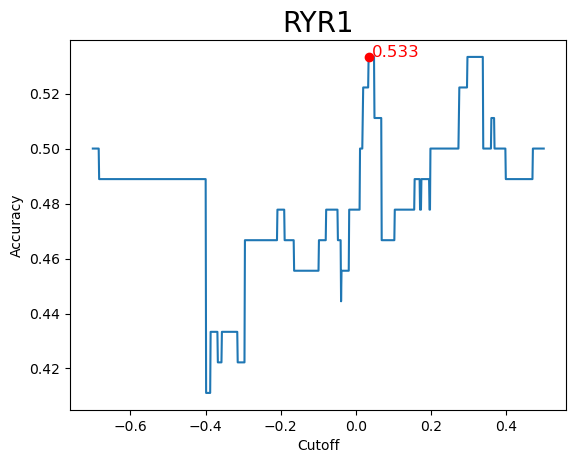

In [77]:
# Plot the relationship between the cutoff and accuracy
cutoffs = np.linspace(-0.7, 0.5, 1000)
accs = []
df_RYR1_alm_copy = df_RYR1_alm.dropna(subset=['labels']).copy()

# pathogenic if prob > cutoff
# benign if prob < cutoff
for cutoff in cutoffs:
    class_ = (df_RYR1_alm_copy['prob'] > cutoff).astype(int)
    acc = accuracy_score(df_RYR1_alm_copy['labels'], class_)
    accs.append(acc)

# Print the highest accuracy with the corresponding cutoff
highest_acc = max(accs)
cutoff = cutoffs[accs.index(highest_acc)]
print('Highest accuracy:', highest_acc)
print('Cutoff:', cutoff)
plt.plot(cutoffs, accs)
plt.xlabel('Cutoff')
plt.ylabel('Accuracy')
plt.plot(cutoff, highest_acc, 'ro')
plt.text(cutoff+0.01, highest_acc, f'%0.3f' % highest_acc, fontsize=12, color='red')
plt.title('RYR1', fontsize=20)
plt.rcParams.update({'font.size': 12})
plt.show()

In [23]:
plot_score_dist(df_RYR1_alm, '', dtype='AlphaMissense',SAV_type = 'RYR1', cutoff=cutoff)

NameError: name 'cutoff' is not defined

F1 score: 0.5116279069767442
Precision: 0.5365853658536586
Recall: 0.4888888888888889
Accuracy: 0.5333333333333333


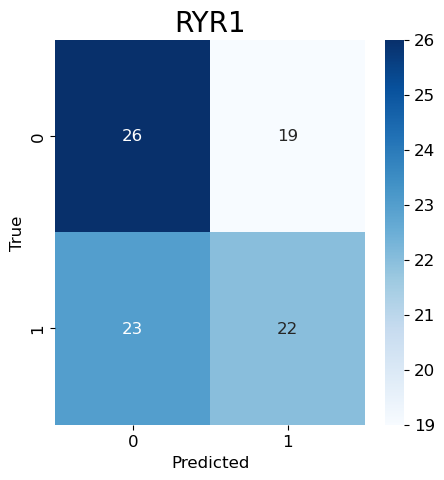

In [79]:

# Generate prediction based on the cutoff
df_RYR1_alm_copy['class'] = (df_RYR1_alm_copy['prob'] > cutoff).astype(int)
conf_matrix, f1, precision, recall, accuracy = get_metrics(df_RYR1_alm_copy, 'RYR1')

In [80]:
RYR1_test = ['P21817 3647 H Q', 'P21817 2163 R C', 'P21817 3028 G S', 'P21817 893 G S',
             'P21817 4833 H Y', 'P21817 3234 N S', 'P21817 2355 R W', 'P21817 530 R H', 'P21817 2342 N S']

df_RYR1_test_alm = df_RYR1_alm_copy[df_RYR1_alm_copy['SAV_coords'].isin(RYR1_test)]
# Calculate accuracy for the test set: labels and class
acc_test = accuracy_score(df_RYR1_test_alm['labels'], df_RYR1_test_alm['class'])
acc_test, df_RYR1_test_alm, 5/len(RYR1_test)

(0.5555555555555556,
          SAV_coords     PDB_coords  labels      prob  p_variant  \
 14  P21817 2342 N S  7M6L A 2342 N     0.0  0.197853     0.2560   
 23   P21817 893 G S   7M6L A 894 G     0.0  0.009997     0.5209   
 25  P21817 3647 H Q  7M6L A 3647 H     0.0 -0.357046     0.8453   
 36  P21817 3028 G S  7M6L A 3028 G     0.0  0.009997     0.1721   
 37  P21817 3234 N S  7M6L A 3234 N     0.0  0.197853     0.0538   
 55   P21817 530 R H   7M6L A 531 R     1.0  0.338604     0.4898   
 61  P21817 2163 R C  7M6L A 2163 R     1.0 -0.399036     0.8767   
 68  P21817 2355 R W  7M6L A 2355 R     1.0  0.068193     0.9184   
 85  P21817 4833 H Y  7M6L A 4832 H     1.0 -0.548055     0.9833   
 
               p_class  class  
 14      likely_benign      1  
 23          ambiguous      0  
 25  likely_pathogenic      0  
 36      likely_benign      0  
 37      likely_benign      1  
 55          ambiguous      1  
 61  likely_pathogenic      0  
 68  likely_pathogenic      1  
 85  like

#### AlphaMissense database

pathogenic: 45
benign: 45


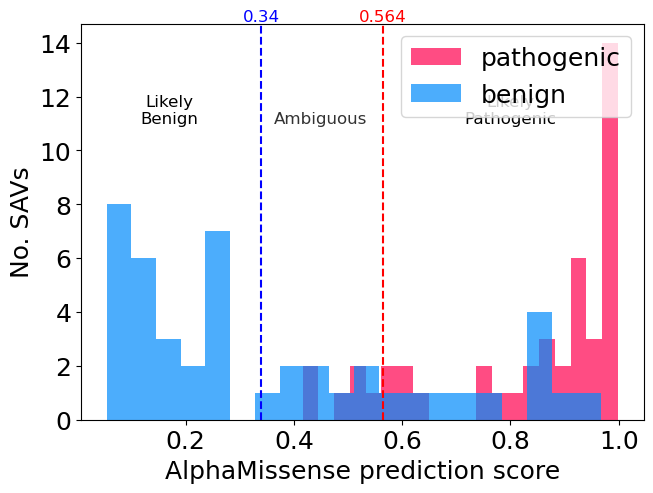

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
axis_color = '#333333'
df_pathogenic = df_RYR1_alm[df_RYR1_alm['labels'] == 1]
df_benign = df_RYR1_alm[df_RYR1_alm['labels'] == 0]
# df_unk = df[(df['labels'] != 0) & (df['labels'] != 1)]

print('pathogenic:', len(df_pathogenic))
print('benign:', len(df_benign))
# print('unknown:', len(df_unk))

# plt.hist(df_pathogenic['prob'], bins=20, alpha=0.7, label='pathogenic', color='lightcoral')
# plt.hist(df_benign['prob'], bins=20, alpha=0.7, label='benign', color='dodgerblue')
blue = (0.0, 0.5433775692459107, 0.983379062301401, 1.0)
red = (1.0, 0.0, 0.3086857038475668, 1.0)
plt.hist(df_pathogenic['p_variant'], bins=20, alpha=0.7, label='pathogenic', color=red)
plt.hist(df_benign['p_variant'], bins=20, alpha=0.7, label='benign', color=blue)
# plt.hist(df_unk['prob'], bins=20, alpha=0.3, label='unknown')

plt.axvline(x=0.34, color='b', linestyle='--', label='')
plt.axvline(x=0.564, color='r', linestyle='--', label='')

plt.legend()
# Denote the cutoffs for pathogenic and benign variants on the plot, on top
plt.text(0.34, 14.8, '0.34', fontsize=12, color='b', ha='center')
plt.text(0.564, 14.8, '0.564', fontsize=12, color='r', ha='center')

plt.text(0.8, 11, 'Likely\nPathogenic', fontsize=12, color='k', ha='center')
plt.text(0.17, 11, 'Likely\nBenign', fontsize=12, color='k', ha='center')

# The middle is ambiguous
plt.text(0.45, 11, 'Ambiguous', fontsize=12, color=axis_color, ha='center')

plt.rcParams.update({'font.size': 12})
plt.tight_layout()
plt.xlabel('AlphaMissense prediction score')
plt.ylabel('No. SAVs')
plt.show()

In [56]:
RYR1_test = ['P21817 2321 I V', 'P21817 2606 C S', 'P21817 35 C R', 'P21817 1109 R K', 
    'P21817 2168 V M', 'P21817 4826 T I', 'P21817 893 G S', 'P21817 4796 Y C', 'P21817 3815 M L']

df_RYR1_test_alm = df_RYR1_alm[df_RYR1_alm['SAV_coords'].isin(RYR1_test)]
# df_RYR1_alm.to_csv(RYR1_alm, sep='\t', index=False)
accuracy = df_RYR1_test_alm['correct'].sum() / len(df_RYR1_test_alm)
accuracy, df_RYR1_test_alm

(0.6666666666666666,
          SAV_coords     PDB_coords  labels      prob  p_variant  \
 3   P21817 2321 I V  7M6L A 2321 I     0.0 -0.387291     0.0986   
 15  P21817 2606 C S  7M6L A 2606 C     0.0  0.360157     0.8325   
 23   P21817 893 G S   7M6L A 894 G     0.0  0.009997     0.5209   
 24  P21817 1109 R K  7M6L A 1110 R     0.0  0.018132     0.1386   
 39  P21817 3815 M L  7M6L A 3816 M     0.0  0.470638     0.6569   
 45    P21817 35 C R    7M6L A 36 C     1.0  0.399036     0.9838   
 63  P21817 2168 V M  7M6L A 2168 V     1.0 -0.296267     0.9242   
 83  P21817 4796 Y C  7M6L A 4795 Y     1.0 -0.189853     0.9840   
 84  P21817 4826 T I  7M6L A 4825 T     1.0  0.368463     0.9698   
 
               p_class  pred  correct  
 3       likely_benign     0        1  
 15  likely_pathogenic     1        0  
 23          ambiguous     1        0  
 24      likely_benign     0        1  
 39  likely_pathogenic     1        0  
 45  likely_pathogenic     1        1  
 63  likely_patho

In [34]:
6/9

0.6666666666666666

pathogenic: 45
benign: 45


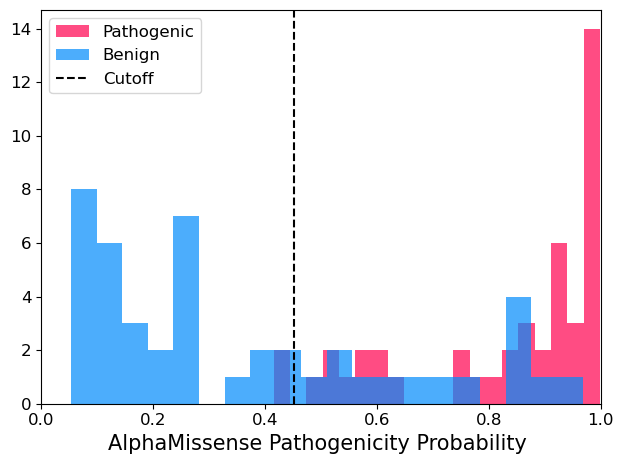

In [24]:
plot_score_dist(df_RYR1_alm, '', dtype='AlphaMissense',SAV_type = 'RYR1', col_name='p_variant', cutoff=(0.34+0.564)/2)

## GJB2

In [44]:
df_GJB2_alm = pd.read_csv(GJB2_alm, sep='\t')
df_GJB2_alm.rename(columns={'alphamissense': 'prob'}, inplace=True)
# plot_score_dist(df_GJB2_alm, '', dtype='AlphaMissense', SAV_type='GJB2')
df_GJB2_alm['pred'] = np.where(df_GJB2_alm['p_variant'] >= 0.452, 1, 0)
df_GJB2_alm['correct'] = np.where(df_GJB2_alm['labels'] == df_GJB2_alm['pred'], 1, 0)

In [47]:
GJB2_test = ['P29033 100 H Q','P29033 50 D N','P29033 115 F V','P29033 44 W S', 'P29033 4 G V']

df_GJB2_test_alm = df_GJB2_alm[df_GJB2_alm['SAV_coords'].isin(GJB2_test)]
# df_RYR1_alm.to_csv(RYR1_alm, sep='\t', index=False)
accuracy = df_GJB2_test_alm['correct'].sum() / len(df_GJB2_test_alm)
accuracy, df_GJB2_test_alm

(0.8,
                                               ClinVar      SAV_coords  \
 3                                                 NaN   P29033 44 W S   
 4                                                 NaN   P29033 50 D N   
 112  NM_NM_004004.6:c.300T>G\tNP_003995.2:p.His100Gln  P29033 100 H Q   
 116    NM_004004.6:c.11G>T\t    NP_003995.2:p.Gly4Val    P29033 4 G V   
 124     NM_004004.6:c.343T>G\tNP_003995.2:p.Phe115Val  P29033 115 F V   
 
        PDB_coords  labels      prob  p_variant            p_class  pred  \
 3     2ZW3 A 44 W     1.0 -0.107153     0.9861  likely_pathogenic     1   
 4     2ZW3 A 50 D     1.0 -0.324250     0.2530      likely_benign     0   
 112  2ZW3 A 100 H     0.0 -0.357081     0.3452          ambiguous     0   
 116    2ZW3 A 4 G     0.0 -0.165309     0.1903      likely_benign     0   
 124  2ZW3 A 115 F     0.0 -0.208957     0.1643      likely_benign     0   
 
      correct  
 3          1  
 4          0  
 112        1  
 116        1  
 124      

#### AlphaMissense source code

Highest accuracy: 0.5957446808510638
Cutoff: -0.03453453453453448


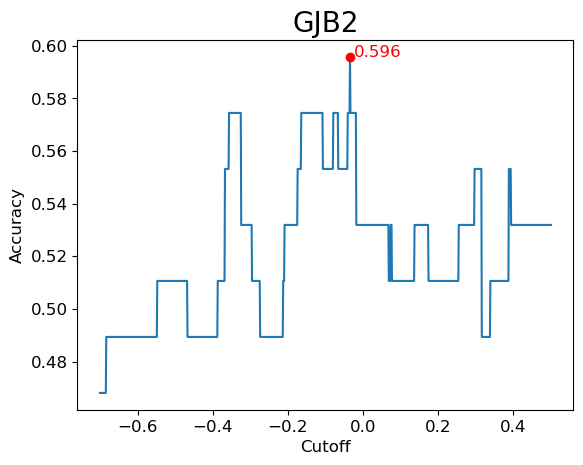

In [84]:
df_GJB2_alm_copy = df_GJB2_alm.dropna(subset=['labels']).copy()
accs = []
for cutoff in cutoffs:
    class_ = (df_GJB2_alm_copy['prob'] > cutoff).astype(int)
    acc = accuracy_score(df_GJB2_alm_copy['labels'], class_)
    accs.append(acc)
highest_acc = max(accs)
cutoff = cutoffs[accs.index(highest_acc)]
print('Highest accuracy:', highest_acc)
print('Cutoff:', cutoff)
plt.plot(cutoffs, accs)
plt.xlabel('Cutoff')
plt.ylabel('Accuracy')
plt.plot(cutoff, highest_acc, 'ro')
plt.text(cutoff+0.01, highest_acc, f'%0.3f' % highest_acc, fontsize=12, color='red')
plt.rcParams.update({'font.size': 12})
plt.title('GJB2', fontsize=20)
plt.show()

pathogenic: 22
benign: 25


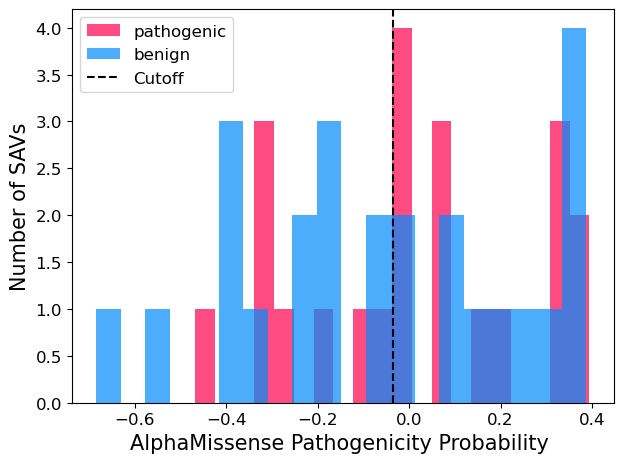

In [85]:
plot_score_dist(df_GJB2_alm, '', dtype='AlphaMissense', SAV_type='GJB2', cutoff=cutoff)

F1 score: 0.5957446808510638
Precision: 0.56
Recall: 0.6363636363636364
Accuracy: 0.5957446808510638


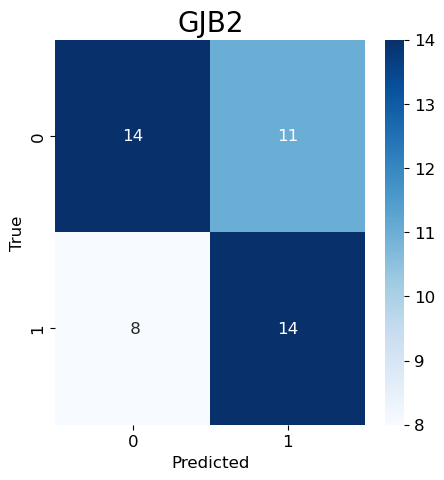

In [86]:
# Generate prediction based on the cutoff
df_GJB2_alm_copy['class'] = (df_GJB2_alm_copy['prob'] > cutoff).astype(int)
conf_matrix, f1, precision, recall, accuracy = get_metrics(df_GJB2_alm_copy, 'GJB2')

In [87]:
SAVs = ['P29033 170 N S' ,'P29033 143 R W' ,'P29033 179 D N' ,'P29033 217 Y D' ,'P29033 16 H Y']
# Predictions on test data  /       alm
# P29033 170 N S	0.012	0       1
# P29033 143 R W	0.962	1       1
# P29033 179 D N	0.815	1       0
# P29033 217 Y D	0.238	0       1
# P29033 16 H Y	0.202	0           0
df_RYR1_alm_copy
check_acc = df_GJB2_alm_copy[df_GJB2_alm_copy['SAV_coords'].isin(SAVs)]
check_acc

,ClinVar,SAV_coords,PDB_coords,labels,prob,p_variant,p_class,class
11,NaN,P29033 143 R W,2ZW3 A 143 R,1.0,0.068179,0.9555,likely_pathogenic,1
14,NaN,P29033 179 D N,2ZW3 A 179 D,1.0,-0.324250,0.8857,likely_pathogenic,0
99,NM_004004.6:c.649T>G\tNP_003995.2:p.Tyr217Asp,P29033 217 Y D,2ZW3 A 217 Y,0.0,0.296840,0.2626,likely_benign,1
106,NM_004004.6:c.509A>G\tNP_003995.2:p.Asn170Ser,P29033 170 N S,2ZW3 A 170 N,0.0,0.197900,0.0489,likely_benign,1
115,NM_004004.6:c.46C>T\t NP_003995.2:p.His16Tyr,P29033 16 H Y,2ZW3 A 16 H,0.0,-0.548055,0.2723,likely_benign,0


#### AlphaMissense database

pathogenic: 22
benign: 25


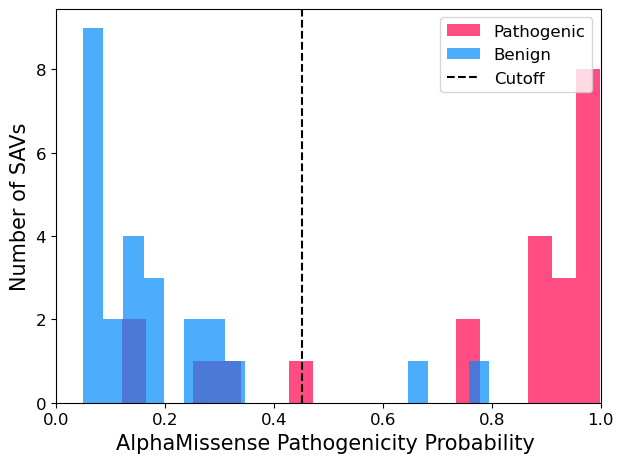

In [26]:
plot_score_dist(df_GJB2_alm, '', dtype='AlphaMissense',SAV_type = 'GJB2', col_name='p_variant', cutoff=(0.34+0.564)/2)

# Rhapsody RF

In [2]:
GJB2_rhd_rf = '/mnt/nas_1/YangLab/loci/tandem/data/GJB2/rhapsody-predictions.csv'
RYR1_rhd_rf = '/mnt/nas_1/YangLab/loci/tandem/data/RYR1/rhapsody-predictions.csv'

## RYR1

pathogenic: 45
benign: 45


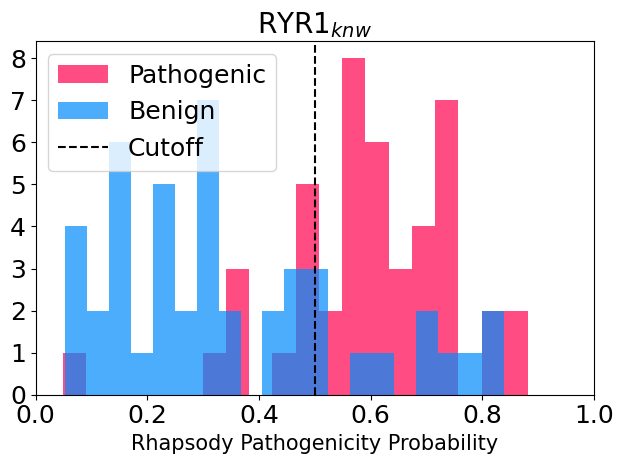

In [9]:
df_RYR1_rhd = pd.read_csv(RYR1_rhd_rf)
plot_score_dist(df_RYR1_rhd, r'RYR1$_{knw}$', dtype='Rhapsody RF', SAV_type='RYR1', cutoff=0.5)

F1 score: 0.7954545454545454
Precision: 0.813953488372093
Recall: 0.7777777777777778
Accuracy: 0.8


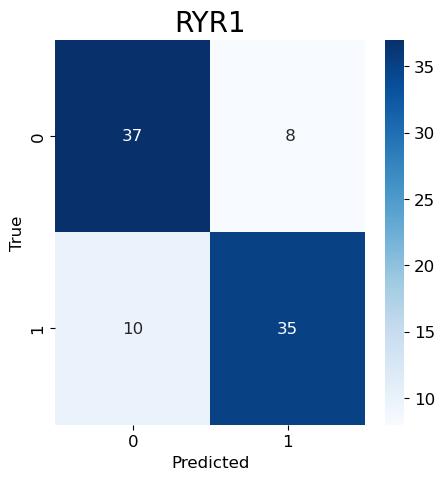

(array([[37,  8],
        [10, 35]]),
 0.7954545454545454,
 0.813953488372093,
 0.7777777777777778,
 0.8)

In [6]:
get_metrics(df_RYR1_rhd, 'RYR1')

In [51]:
RYR1_test = ['P21817 2321 I V', 'P21817 2606 C S', 'P21817 35 C R', 'P21817 1109 R K', 
    'P21817 2168 V M', 'P21817 4826 T I', 'P21817 893 G S', 'P21817 4796 Y C', 'P21817 3815 M L']
# ['P21817 3647 H Q', 'P21817 2163 R C', 'P21817 3028 G S', 'P21817 893 G S',
#              'P21817 4833 H Y', 'P21817 3234 N S', 'P21817 2355 R W', 'P21817 530 R H', 'P21817 2342 N S']

df_RYR1_test_rhd = df_RYR1_rhd[df_RYR1_rhd['SAV_coords'].isin(RYR1_test)]
# Calculate accuracy for the test set: labels and class
# acc_test = accuracy_score(df_RYR1_test_rhd['labels'], df_RYR1_test_rhd['class'])
# acc_test, df_RYR1_test_rhd, 5/len(RYR1_test)
df_RYR1_test_rhd
df_RYR1_test_rhd['correct'].sum() / df_RYR1_test_rhd.__len__(), df_RYR1_test_rhd

(0.7777777777777778,
          SAV_coords  score   prob           class  pred  labels  correct
 0     P21817 35 C R  0.935  0.868  deleterious      1.0     1.0      1.0
 18  P21817 2168 V M  0.845  0.726  deleterious      1.0     1.0      1.0
 38  P21817 4796 Y C  0.892  0.805  deleterious      1.0     1.0      1.0
 39  P21817 4826 T I  0.712  0.520  prob.delet.      1.0     1.0      1.0
 48  P21817 2321 I V  0.333  0.154  neutral          0.0     0.0      1.0
 60  P21817 2606 C S  0.811  0.690  deleterious      1.0     0.0      0.0
 68   P21817 893 G S  0.849  0.734  deleterious      1.0     0.0      0.0
 69  P21817 1109 R K  0.246  0.098  neutral          0.0     0.0      1.0
 84  P21817 3815 M L  0.307  0.164  neutral          0.0     0.0      1.0)

## GJB2

pathogenic: 22
benign: 25


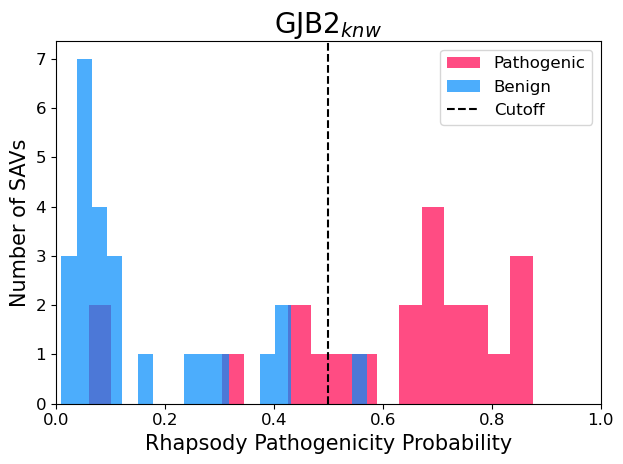

In [48]:
df_GJB2_rhd = pd.read_csv(GJB2_rhd_rf)
plot_score_dist(df_GJB2_rhd, r'GJB2$_{knw}$', dtype='Rhapsody RF', SAV_type='GJB2', cutoff=0.5)

F1 score: 0.8421052631578947
Precision: 1.0
Recall: 0.7272727272727273
Accuracy: 0.8723404255319149


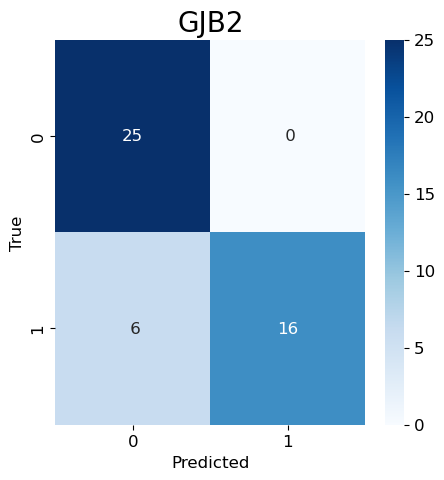

(array([[25,  0],
        [ 6, 16]]),
 0.8421052631578947,
 1.0,
 0.7272727272727273,
 0.8723404255319149)

In [95]:
get_metrics(df_GJB2_rhd, 'GJB2')

In [25]:
df_GJB2_rhd

,SAV_coords,score,prob,class,pred,labels,correct
0,P29033 217 Y D,0.588,0.401,neutral,0.0,0.0,1.0
1,P29033 215 I M,0.216,0.085,neutral,0.0,0.0,1.0
2,P29033 214 L V,0.070,0.031,neutral,0.0,0.0,1.0
3,P29033 210 L V,0.274,0.115,neutral,0.0,0.0,1.0
4,P29033 203 I T,0.745,0.571,deleterious,1.0,0.0,0.0
...,...,...,...,...,...,...,...
125,P29033 18 T S,0.880,0.785,deleterious,1.0,NaN,0.0
126,P29033 17 S C,0.801,0.659,deleterious,1.0,NaN,0.0
127,P29033 16 H P,0.860,0.752,deleterious,1.0,NaN,0.0
128,P29033 13 V G,0.890,0.802,deleterious,1.0,NaN,0.0


In [50]:
GJB2_test = ['P29033 107 I L','P29033 195 M T','P29033 114 E G','P29033 163 M T','P29033 165 R W']

df_GJB2_test_rhd = df_GJB2_rhd[df_GJB2_rhd['SAV_coords'].isin(GJB2_test)]
# Calculate accuracy for the test set: labels and class
df_GJB2_test_rhd['correct'].sum() / df_GJB2_test_rhd.__len__(), df_GJB2_test_rhd

(1.0,
         SAV_coords  score   prob           class  pred  labels  correct
 15  P29033 114 E G  0.143  0.059  neutral          0.0     0.0      1.0
 17  P29033 107 I L  0.100  0.040  neutral          0.0     0.0      1.0
 24  P29033 165 R W  0.449  0.245  neutral          0.0     0.0      1.0
 39  P29033 163 M T  0.731  0.549  prob.delet.      1.0     1.0      1.0
 42  P29033 195 M T  0.879  0.784  deleterious      1.0     1.0      1.0)

# Predictions of unknown SAVs

In [96]:
import pandas as pd

df_GJB2 = pd.read_csv('/mnt/nas_1/YangLab/loci/NativeEnsembleWeb_copy/improve/train/logs/thesis-transfer_GJB2/improve-20240707-0848-seed-2105-n_hidden-6/GJB2_nan_pathogenicity_pred_total.csv')
df_GJB2 = df_GJB2.drop(columns=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', 'final_prob_sem'])
df_GJB2.columns = ['SAV_coords', 'decision', 'voting', 'patho. prob.']
df_GJB2['decision'] = df_GJB2['decision'].astype(object)

df_GJB2_alm = pd.read_csv('/mnt/nas_1/YangLab/loci/NativeEnsembleWeb_copy/improve/data/GJB2/GJB2_alm_Jul18.tsv', sep='\t')
df_GJB2_rhd = pd.read_csv('/mnt/nas_1/YangLab/loci/NativeEnsembleWeb_copy/improve/data/GJB2/rhd_preds.tsv', sep='\t')
df_GJB2_rhd.head(2)

,SAV coords,training info,score,path. prob.,path. class,PolyPhen-2 score,PolyPhen-2 path. class,EVmutation score,EVmutation path. class
0,P29033 217 Y D,new,0.578000,0.390498,neutral,0.245,neutral,-2.8104,neutral
1,P29033 215 I M,new,0.184667,0.088520,neutral,0.008,neutral,-3.3396,neutral


In [97]:
for i, row in df_GJB2.iterrows():
    df_GJB2.at[i, 'decision'] = 'pathogenic' if int(row['decision']) == 1 else 'benign'
    df_GJB2.at[i, 'AlphaMissense patho. prob.'] = df_GJB2_alm[df_GJB2_alm['SAV_coords'] == row['SAV_coords']]['p_variant'].values[0]
    df_GJB2.at[i, 'AlphaMissense decision']     = df_GJB2_alm[df_GJB2_alm['SAV_coords'] == row['SAV_coords']]['p_class'].values[0]
    df_GJB2.at[i, 'Rhapsody patho. prob.']      = df_GJB2_rhd[df_GJB2_rhd['SAV coords'] == row['SAV_coords']]['path. prob.'].values[0]
    df_GJB2.at[i, 'Rhapsody decision']          = df_GJB2_rhd[df_GJB2_rhd['SAV coords'] == row['SAV_coords']]['path. class'].values[0]
df_GJB2

,SAV_coords,decision,voting,patho. prob.,AlphaMissense patho. prob.,AlphaMissense decision,Rhapsody patho. prob.,Rhapsody decision
0,P29033 216 R I,pathogenic,1.0,0.757232,0.3616,ambiguous,0.304944,neutral
1,P29033 209 E D,pathogenic,1.0,0.933005,0.9888,likely_pathogenic,0.498399,prob.neutral
2,P29033 209 E G,pathogenic,1.0,0.971832,0.9814,likely_pathogenic,0.775720,deleterious
3,P29033 207 V L,benign,1.0,0.048180,0.1354,likely_benign,0.049291,neutral
4,P29033 201 I M,benign,1.0,0.394138,0.1501,likely_benign,0.243636,neutral
...,...,...,...,...,...,...,...,...
75,P29033 18 T S,pathogenic,1.0,0.760685,0.8019,likely_pathogenic,0.747443,deleterious
76,P29033 17 S C,pathogenic,1.0,0.940924,0.8313,likely_pathogenic,0.446993,neutral
77,P29033 16 H P,pathogenic,1.0,0.808758,0.9235,likely_pathogenic,0.585998,deleterious
78,P29033 13 V G,pathogenic,1.0,0.822178,0.7236,likely_pathogenic,0.603180,deleterious


In [98]:
df_GJB2.to_csv('unk_GJB2_predictions.tsv', sep='\t', index=False)

# Comparison between three tools

In [1]:
import pandas as pd
df_GJB2 = pd.read_csv('GJB2_unk_predictions_among_tools_Y1_L2.csv')
df_GJB2 = df_GJB2.drop(columns=['Unnamed: 10', 'Unnamed: 11'])

import pandas as pd
df_RYR1 = pd.read_csv('RYR1_unk_preds.csv')
df_RYR1 = df_RYR1.drop(columns=['Unnamed: 9'])

for i, row in df_RYR1.iterrows():
    SAV_coord = row['SAV_coords'].split(' ')
    Mutation = f'{SAV_coord[2]}{SAV_coord[1]}{SAV_coord[3]}'
    df_RYR1.at[i, 'Mutation'] = Mutation

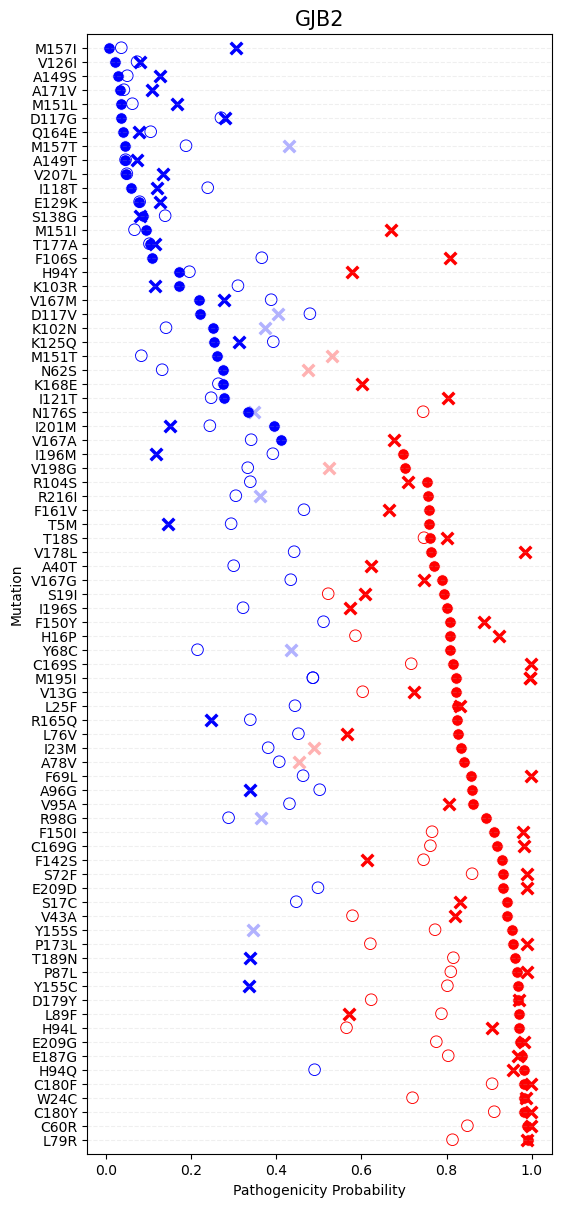

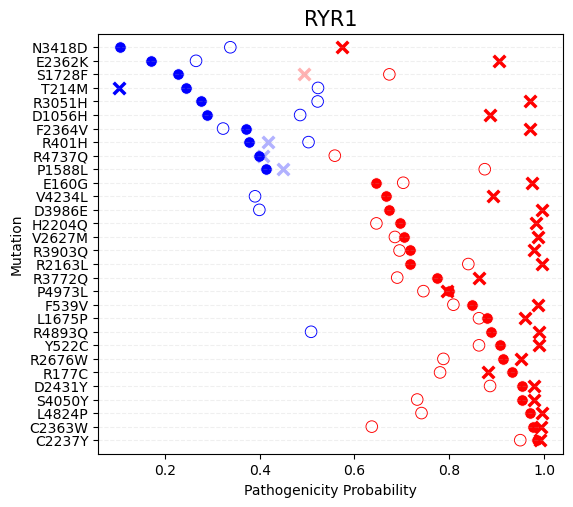

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

df = df_GJB2
plt.figure(figsize=(6, df.shape[0]/5.5))
plt.rcParams.update({'font.size': 10})
size = 70
# GJB2: 80 samples
tandem_patho = df[df['decision'] == 'pathogenic']
tandem_benign = df[df['decision'] == 'benign']
sns.scatterplot( data=tandem_patho, x='patho. prob.', y='Mutation', label=r'TANDEM$_{GJB2/RYR1}$ Pathogenic', marker='o', color='r', s=size)
sns.scatterplot( data=tandem_benign, x='patho. prob.', y='Mutation', label=r'TANDEM$_{GJB2/RYR1}$ Benign', marker='o', color='b', s=size)

# x, colorize as red for pathogenic (alm_score>0.452), blue for benign (alm_score<0.452)
alm_patho = df[df['AlphaMissense decision'] == 'likely_pathogenic']
alm_benign = df[df['AlphaMissense decision'] == 'likely_benign']
alm_ambiguous = df[df['AlphaMissense decision'] == 'ambiguous']

alm_ambiguous_patho = alm_ambiguous[alm_ambiguous['Refined AlphaMissense decision (cutoff 0.452)'] == 'likely_pathogenic']
alm_ambiguous_benign = alm_ambiguous[alm_ambiguous['Refined AlphaMissense decision (cutoff 0.452)'] == 'likely_benign']
sns.scatterplot( data=alm_patho, x='AlphaMissense patho. prob.', y='Mutation', label=r'AlphaMissense Pathogenic', marker='x', color='r', linewidth=2.5, s=size)
sns.scatterplot( data=alm_benign, x='AlphaMissense patho. prob.', y='Mutation', label=r'AlphaMissense Benign', marker='x', color='b', linewidth=2.5, s=size)
sns.scatterplot( data=alm_ambiguous_patho, x='AlphaMissense patho. prob.', y='Mutation', marker='x', color='r', alpha=0.3, linewidth=2.5, s=size)
sns.scatterplot( data=alm_ambiguous_benign, x='AlphaMissense patho. prob.', y='Mutation', marker='x', color='b', alpha=0.3, linewidth=2.5, s=size)

# unfilled circle
rhd_patho = df[(df['Rhapsody decision'] == 'deleterious') | (df['Rhapsody decision'] == 'prob.delet.')]
rhd_benign = df[(df['Rhapsody decision'] == 'neutral') | (df['Rhapsody decision'] == 'prob.neutral')]
sns.scatterplot( data=rhd_patho, x='Rhapsody patho. prob.', y='Mutation', label=r'Rhapsody Pathogenic', marker='o', color='r', facecolors='none', edgecolors='r', s=size)
sns.scatterplot( data=rhd_benign, x='Rhapsody patho. prob.', y='Mutation', label=r'Rhapsody Benign', marker='o', color='b', facecolors='none', edgecolors='b', s=size)

plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.xlabel('Pathogenicity Probability')
plt.ylabel('Mutation')
plt.legend().remove()
plt.ylim(-1, df.shape[0]-1)
plt.title('GJB2', fontsize=15)
plt.show()


df = df_RYR1
plt.figure(figsize=(6, df.shape[0]/5.5))
plt.rcParams.update({'font.size': 10})
size = 70
# GJB2: 80 samples
tandem_patho = df[df['decision'] == 'pathogenic']
tandem_benign = df[df['decision'] == 'benign']
sns.scatterplot( data=tandem_patho, x='patho. prob.', y='Mutation', label=r'TANDEM$_{GJB2/RYR1}$ Pathogenic', marker='o', color='r', s=size)
sns.scatterplot( data=tandem_benign, x='patho. prob.', y='Mutation', label=r'TANDEM$_{GJB2/RYR1}$ Benign', marker='o', color='b', s=size)

# x, colorize as red for pathogenic (alm_score>0.452), blue for benign (alm_score<0.452)
alm_patho = df[df['AlphaMissense decision'] == 'likely_pathogenic']
alm_benign = df[df['AlphaMissense decision'] == 'likely_benign']
alm_ambiguous = df[df['AlphaMissense decision'] == 'ambiguous']

alm_ambiguous_patho = alm_ambiguous[alm_ambiguous['Refined AlphaMissense decision (cutoff 0.452)'] == 'likely_pathogenic']
alm_ambiguous_benign = alm_ambiguous[alm_ambiguous['Refined AlphaMissense decision (cutoff 0.452)'] == 'likely_benign']
sns.scatterplot( data=alm_patho, x='AlphaMissense patho. prob.', y='Mutation', label=r'AlphaMissense Pathogenic', marker='x', color='r', linewidth=2.5, s=size)
sns.scatterplot( data=alm_benign, x='AlphaMissense patho. prob.', y='Mutation', label=r'AlphaMissense Benign', marker='x', color='b', linewidth=2.5, s=size)
sns.scatterplot( data=alm_ambiguous_patho, x='AlphaMissense patho. prob.', y='Mutation', marker='x', color='r', alpha=0.3, linewidth=2.5, s=size)
sns.scatterplot( data=alm_ambiguous_benign, x='AlphaMissense patho. prob.', y='Mutation', marker='x', color='b', alpha=0.3, linewidth=2.5, s=size)

# unfilled circle
rhd_patho = df[(df['Rhapsody decision'] == 'deleterious') | (df['Rhapsody decision'] == 'prob.delet.')]
rhd_benign = df[(df['Rhapsody decision'] == 'neutral') | (df['Rhapsody decision'] == 'prob.neutral')]
sns.scatterplot( data=rhd_patho, x='Rhapsody patho. prob.', y='Mutation', label=r'Rhapsody Pathogenic', marker='o', color='r', facecolors='none', edgecolors='r', s=size)
sns.scatterplot( data=rhd_benign, x='Rhapsody patho. prob.', y='Mutation', label=r'Rhapsody Benign', marker='o', color='b', facecolors='none', edgecolors='b', s=size)

plt.xlabel('Pathogenicity Probability')
plt.ylabel('Mutation')
plt.title('RYR1', fontsize=15)
plt.legend().remove()
plt.ylim(-1, df.shape[0])
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.show()

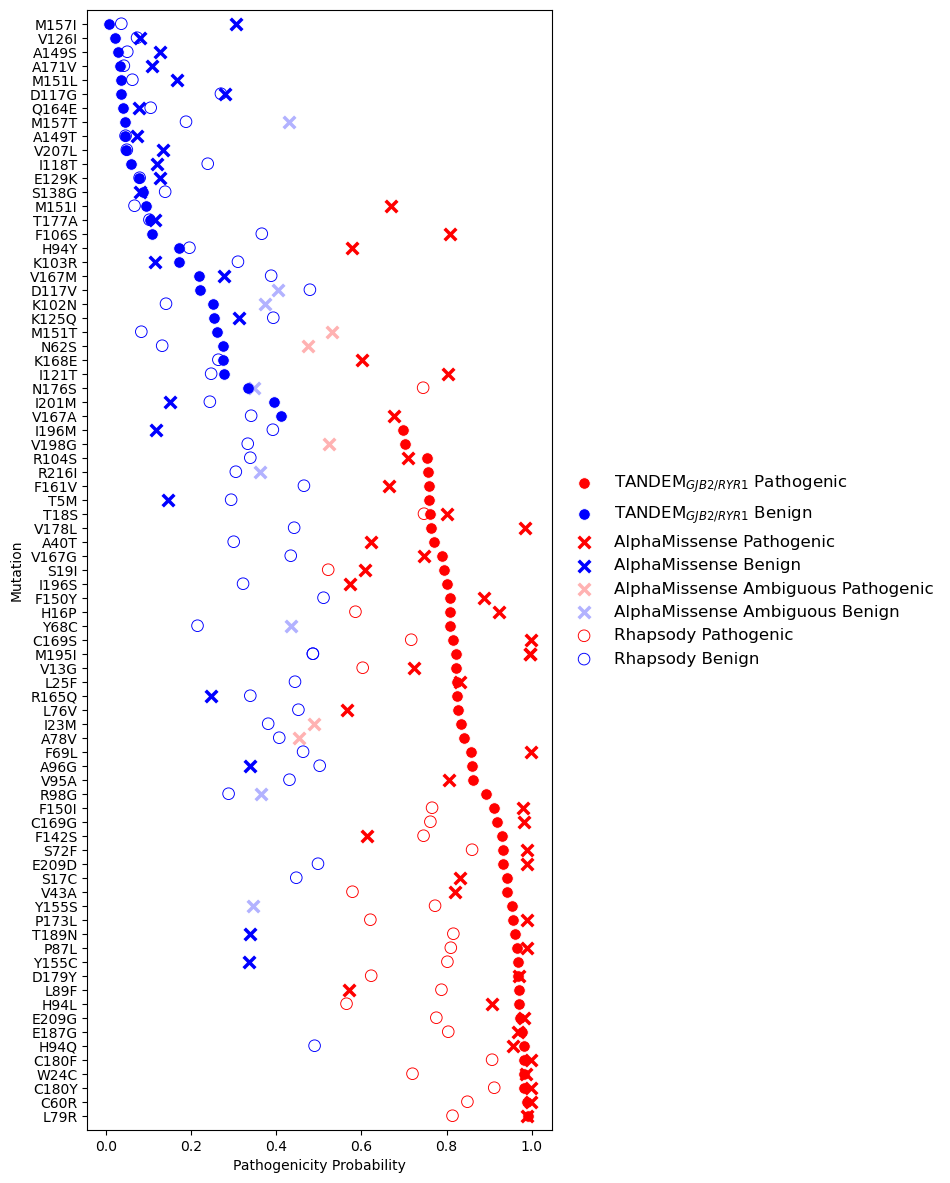

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

df = df_GJB2
plt.figure(figsize=(6, df.shape[0]/5.5))
plt.rcParams.update({'font.size': 10})
size = 70
# GJB2: 80 samples
tandem_patho = df[df['decision'] == 'pathogenic']
tandem_benign = df[df['decision'] == 'benign']
sns.scatterplot( data=tandem_patho, x='patho. prob.', y='Mutation', label=r'TANDEM$_{GJB2/RYR1}$ Pathogenic', marker='o', color='r', s=size)
sns.scatterplot( data=tandem_benign, x='patho. prob.', y='Mutation', label=r'TANDEM$_{GJB2/RYR1}$ Benign', marker='o', color='b', s=size)

# x, colorize as red for pathogenic (alm_score>0.452), blue for benign (alm_score<0.452)
alm_patho = df[df['AlphaMissense decision'] == 'likely_pathogenic']
alm_benign = df[df['AlphaMissense decision'] == 'likely_benign']
alm_ambiguous = df[df['AlphaMissense decision'] == 'ambiguous']

alm_ambiguous_patho = alm_ambiguous[alm_ambiguous['Refined AlphaMissense decision (cutoff 0.452)'] == 'likely_pathogenic']
alm_ambiguous_benign = alm_ambiguous[alm_ambiguous['Refined AlphaMissense decision (cutoff 0.452)'] == 'likely_benign']
sns.scatterplot( data=alm_patho, x='AlphaMissense patho. prob.', y='Mutation', label=r'AlphaMissense Pathogenic', marker='x', color='r', linewidth=2.5, s=size)
sns.scatterplot( data=alm_benign, x='AlphaMissense patho. prob.', y='Mutation', label=r'AlphaMissense Benign', marker='x', color='b', linewidth=2.5, s=size)
sns.scatterplot( data=alm_ambiguous_patho, x='AlphaMissense patho. prob.', y='Mutation', marker='x', color='r', alpha=0.3, linewidth=2.5, s=size,
                label='AlphaMissense Ambiguous Pathogenic')
sns.scatterplot( data=alm_ambiguous_benign, x='AlphaMissense patho. prob.', y='Mutation', marker='x', color='b', alpha=0.3, linewidth=2.5, s=size,
                label='AlphaMissense Ambiguous Benign')

# unfilled circle
rhd_patho = df[(df['Rhapsody decision'] == 'deleterious') | (df['Rhapsody decision'] == 'prob.delet.')]
rhd_benign = df[(df['Rhapsody decision'] == 'neutral') | (df['Rhapsody decision'] == 'prob.neutral')]
sns.scatterplot( data=rhd_patho, x='Rhapsody patho. prob.', y='Mutation', label=r'Rhapsody Pathogenic', marker='o', color='r', facecolors='none', edgecolors='r', s=size)
sns.scatterplot( data=rhd_benign, x='Rhapsody patho. prob.', y='Mutation', label=r'Rhapsody Benign', marker='o', color='b', facecolors='none', edgecolors='b', s=size)


plt.xlabel('Pathogenicity Probability')
plt.ylabel('Mutation')
# plt.title(f'VUS predictions for {gene}', fontsize=20)
# plt.tight_layout()

# Remove legend
plt.legend(ncol=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, frameon=False)

# y-axis range 
plt.ylim(-1, df.shape[0]-1)



plt.show()


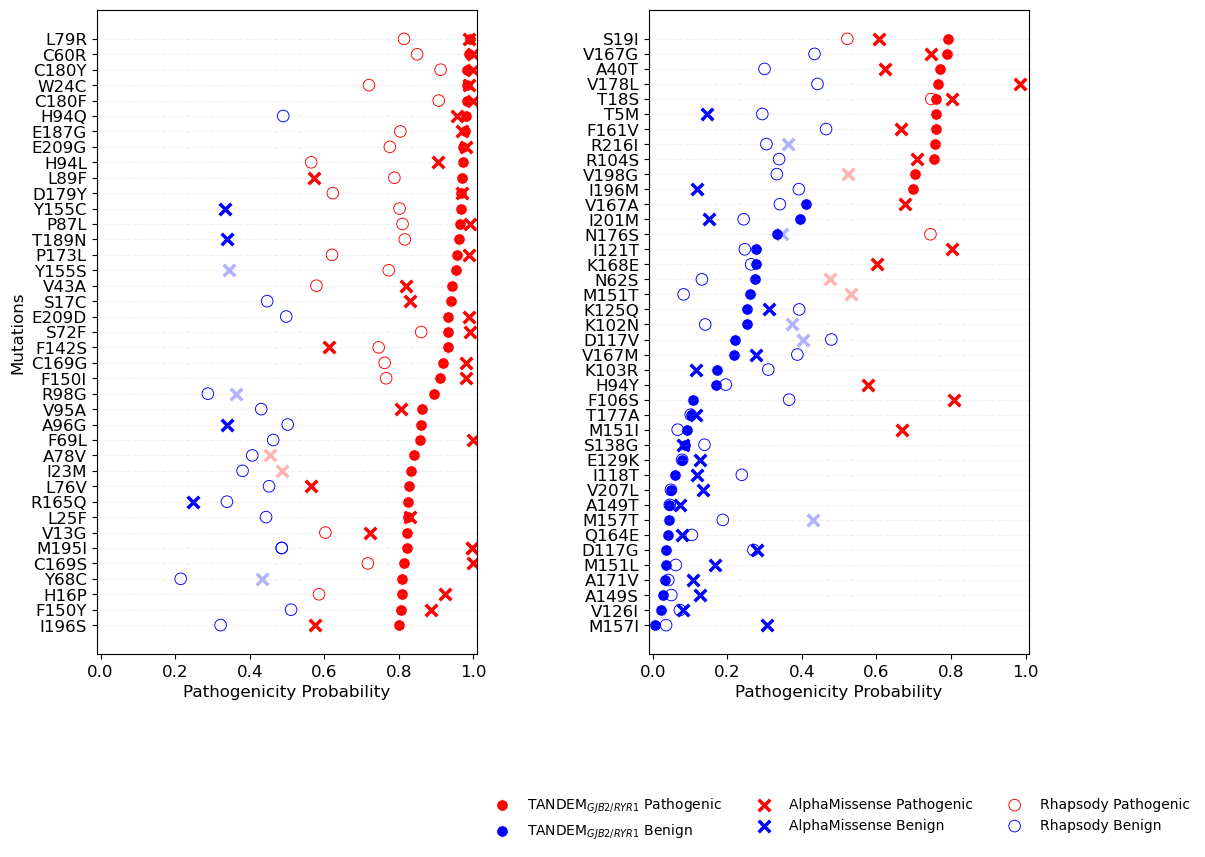

In [76]:
# Plot x-axis: mutation, y-axis: pathogenicity score of 3 tools
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12, 1.1*df.shape[0]/10))

def plot_VUS_predictions(df):
    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(1, 2, figsize=(12, 1.1*df.shape[0]/10))
    df_ = [df.iloc[: len(df)//2], df.iloc[len(df)//2:]]

    size = 70
    for i, _df_ in enumerate(df_):
        # circle
        # Colorize as red for pathogenic (tandem_score>0.5), blue for benign (tandem_score<0.5)
        tandem_patho = _df_[_df_['decision'] == 'pathogenic']
        tandem_benign = _df_[_df_['decision'] == 'benign']
        sns.scatterplot( data=tandem_patho, x='patho. prob.', y='Mutation', label=r'TANDEM$_{GJB2/RYR1}$ Pathogenic', marker='o', color='r', ax=ax[i], s=size)
        sns.scatterplot( data=tandem_benign, x='patho. prob.', y='Mutation', label=r'TANDEM$_{GJB2/RYR1}$ Benign', marker='o', color='b', ax=ax[i], s=size)

        # x, colorize as red for pathogenic (alm_score>0.452), blue for benign (alm_score<0.452)
        alm_patho = _df_[_df_['AlphaMissense decision'] == 'likely_pathogenic']
        alm_benign = _df_[_df_['AlphaMissense decision'] == 'likely_benign']
        alm_ambiguous = _df_[_df_['AlphaMissense decision'] == 'ambiguous']

        alm_ambiguous_patho = alm_ambiguous[alm_ambiguous['Refined AlphaMissense decision (cutoff 0.452)'] == 'likely_pathogenic']
        alm_ambiguous_benign = alm_ambiguous[alm_ambiguous['Refined AlphaMissense decision (cutoff 0.452)'] == 'likely_benign']
        sns.scatterplot( data=alm_patho, x='AlphaMissense patho. prob.', y='Mutation', label=r'AlphaMissense Pathogenic', marker='x', color='r', ax=ax[i], linewidth=2.5, s=size)
        sns.scatterplot( data=alm_benign, x='AlphaMissense patho. prob.', y='Mutation', label=r'AlphaMissense Benign', marker='x', color='b', ax=ax[i], linewidth=2.5, s=size)
        sns.scatterplot( data=alm_ambiguous_patho, x='AlphaMissense patho. prob.', y='Mutation', marker='x', color='r', alpha=0.3, ax=ax[i], linewidth=2.5, s=size)
        sns.scatterplot( data=alm_ambiguous_benign, x='AlphaMissense patho. prob.', y='Mutation', marker='x', color='b', alpha=0.3, ax=ax[i], linewidth=2.5, s=size)

        # unfilled circle
        # sns.scatterplot(y=mutation, x=rhd_score, label='Rhapsody', marker='o', facecolors='none', edgecolors='r')
        rhd_patho = _df_[(_df_['Rhapsody decision'] == 'deleterious') | (_df_['Rhapsody decision'] == 'prob.delet.')]
        rhd_benign = _df_[(_df_['Rhapsody decision'] == 'neutral') | (_df_['Rhapsody decision'] == 'prob.neutral')]
        sns.scatterplot( data=rhd_patho, x='Rhapsody patho. prob.', y='Mutation', label=r'Rhapsody Pathogenic', marker='o', color='r', ax=ax[i], facecolors='none', edgecolors='r', s=size)
        sns.scatterplot( data=rhd_benign, x='Rhapsody patho. prob.', y='Mutation', label=r'Rhapsody Benign', marker='o', color='b', ax=ax[i], facecolors='none', edgecolors='b', s=size)

        ax[i].set_xlabel('Pathogenicity Probability')
        ax[i].grid(axis='y', linestyle='--', alpha=0.2)

        # ax[i].xlim(0, 1)
        ax[i].set_xlim(-0.01, 1.01)

    ax[0].set_ylabel('Mutations')
    ax[0].get_legend().remove()

    ax[1].set_ylabel('')
    ax[1].get_legend().remove()
    
    # ax[1].legend(fontsize=10, loc=[1.01, 0.5])

    plt.legend(
        fontsize=10, 
        loc='upper center',  # Center the legend horizontally relative to the bbox
        bbox_to_anchor=(0.5, -0.2),  # Adjust these values to place the legend below the x-axis title
        ncol=3,  # Number of columns in the legend
        frameon=False  # Remove the legend frame
    )

    plt.tight_layout()
    plt.show()

plot_VUS_predictions(df)

In [72]:
import pandas as pd
df = pd.read_csv('RYR1_unk_preds.csv')
df = df.drop(columns=['Unnamed: 9'])

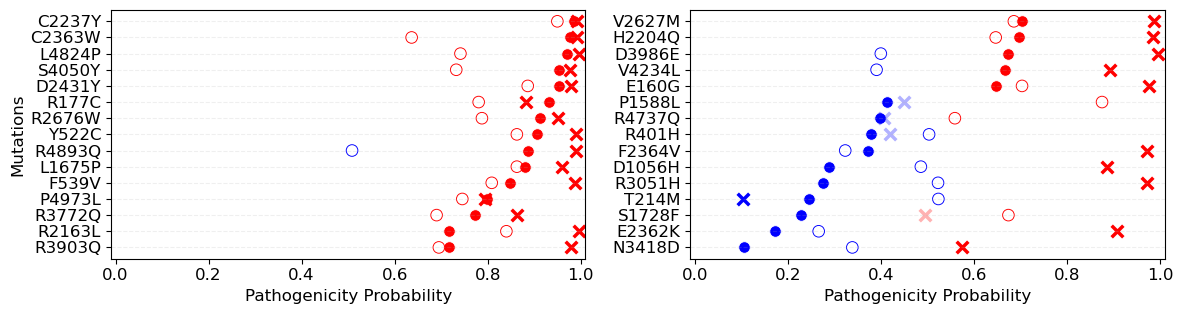

In [73]:
for i, row in df.iterrows():
    SAV_coord = row['SAV_coords'].split(' ')
    Mutation = f'{SAV_coord[2]}{SAV_coord[1]}{SAV_coord[3]}'
    df.at[i, 'Mutation'] = Mutation
plot_VUS_predictions(df)

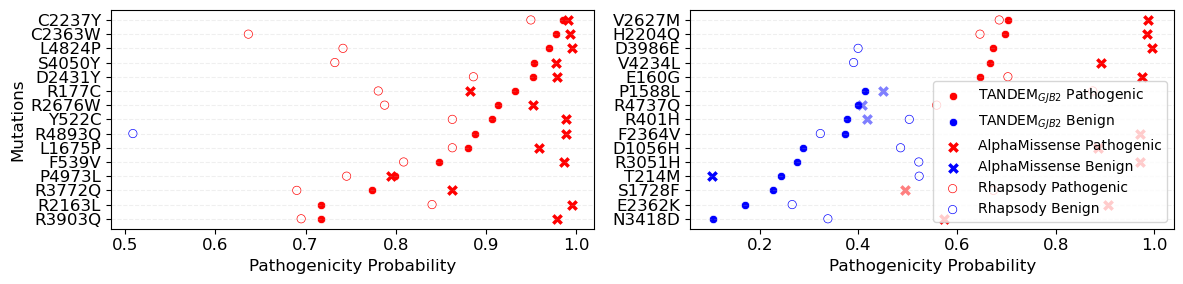

In [26]:
# Plot x-axis: mutation, y-axis: pathogenicity score of 3 tools
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(1, 2, figsize=(12, df.shape[0]/10))

for i, _df_ in enumerate(df_):
    mutation = _df_['Mutation']
    tandem_score = _df_['patho. prob.']
    alm_score = _df_['AlphaMissense patho. prob.']
    rhd_score = _df_['Rhapsody patho. prob.']

    # circle
    # Colorize as red for pathogenic (tandem_score>0.5), blue for benign (tandem_score<0.5)
    tandem_patho = _df_[_df_['decision'] == 'pathogenic']
    tandem_benign = _df_[_df_['decision'] == 'benign']
    sns.scatterplot(y=tandem_patho['Mutation'], x=tandem_patho['patho. prob.'], label=r'TANDEM$_{GJB2}$ Pathogenic', marker='o', color='r', ax=ax[i])
    sns.scatterplot(y=tandem_benign['Mutation'], x=tandem_benign['patho. prob.'], label=r'TANDEM$_{GJB2}$ Benign', marker='o', color='b', ax=ax[i])

    # x, colorize as red for pathogenic (alm_score>0.452), blue for benign (alm_score<0.452)

    alm_patho = _df_[_df_['AlphaMissense decision'] == 'likely_pathogenic']
    alm_benign = _df_[_df_['AlphaMissense decision'] == 'likely_benign']
    alm_ambiguous = _df_[_df_['AlphaMissense decision'] == 'ambiguous']

    alm_ambiguous_patho = alm_ambiguous[alm_ambiguous['Refined AlphaMissense decision (cutoff 0.452)'] == 'likely_pathogenic']
    alm_ambiguous_benign = alm_ambiguous[alm_ambiguous['Refined AlphaMissense decision (cutoff 0.452)'] == 'likely_benign']
    sns.scatterplot(y=alm_patho['Mutation'], x=alm_patho['AlphaMissense patho. prob.'], label=r'AlphaMissense Pathogenic', marker='x', color='r', linewidth=2.5, ax=ax[i])
    sns.scatterplot(y=alm_benign['Mutation'], x=alm_benign['AlphaMissense patho. prob.'], label=r'AlphaMissense Benign', marker='x', color='b', linewidth=2.5, ax=ax[i])
    # sns.scatterplot(y=alm_ambiguous['Mutation'], x=alm_ambiguous['AlphaMissense patho. prob.'], label=r'AlphaMissense Ambiguous', marker='x', color='k', linewidth=2.5, ax=ax[i])
    sns.scatterplot(y=alm_ambiguous_patho['Mutation'], x=alm_ambiguous_patho['AlphaMissense patho. prob.'], marker='x', color='r', alpha=0.5, linewidth=2.5, ax=ax[i])
    sns.scatterplot(y=alm_ambiguous_benign['Mutation'], x=alm_ambiguous_benign['AlphaMissense patho. prob.'], marker='x', color='b', alpha=0.5, linewidth=2.5, ax=ax[i])

    # unfilled circle
    # sns.scatterplot(y=mutation, x=rhd_score, label='Rhapsody', marker='o', facecolors='none', edgecolors='r')
    rhd_patho = _df_[(_df_['Rhapsody decision'] == 'deleterious') | (_df_['Rhapsody decision'] == 'prob.delet.')]
    rhd_benign = _df_[(_df_['Rhapsody decision'] == 'neutral') | (_df_['Rhapsody decision'] == 'prob.neutral')]
    sns.scatterplot(y=rhd_patho['Mutation'], x=rhd_patho['Rhapsody patho. prob.'], label=r'Rhapsody Pathogenic', marker='o', color='r', facecolors='none', edgecolors='r', ax=ax[i])
    sns.scatterplot(y=rhd_benign['Mutation'], x=rhd_benign['Rhapsody patho. prob.'], label=r'Rhapsody Benign', marker='o', color='b', facecolors='none', edgecolors='b', ax=ax[i])

    ax[i].set_xlabel('Pathogenicity Probability')
    ax[i].grid(axis='y', linestyle='--', alpha=0.2)

ax[0].set_ylabel('Mutations')
ax[0].get_legend().remove()

ax[1].set_ylabel('')
ax[1].legend(fontsize=10)
plt.tight_layout()
plt.show()

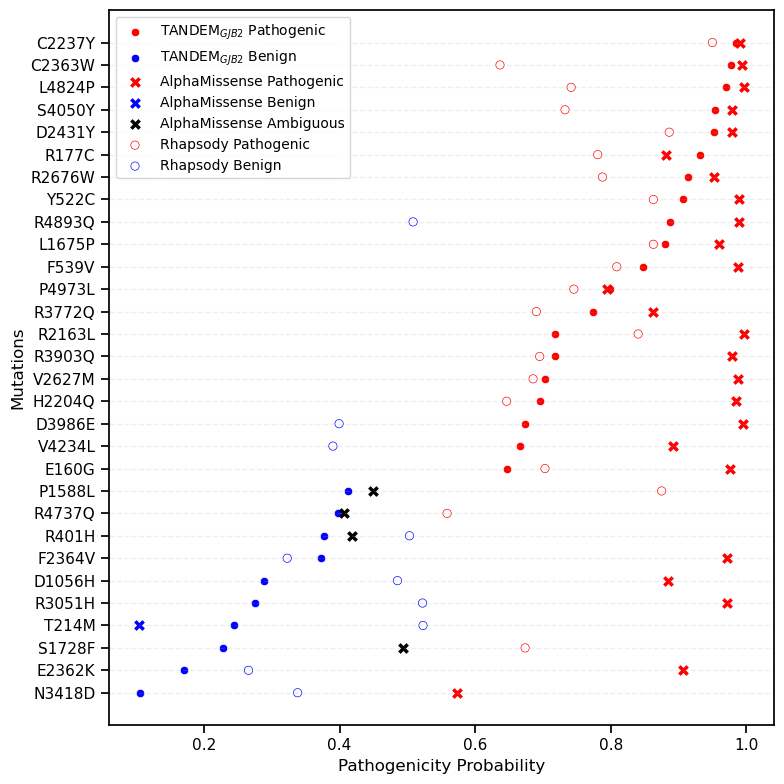

In [171]:
# Plot x-axis: mutation, y-axis: pathogenicity score of 3 tools
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(8, 8))
mutation = df['Mutation']
tandem_score = df['patho. prob.']
alm_score = df['AlphaMissense patho. prob.']
rhd_score = df['Rhapsody patho. prob.']

# circle
# Colorize as red for pathogenic (tandem_score>0.5), blue for benign (tandem_score<0.5)
tandem_patho = df[df['decision'] == 'pathogenic']
tandem_benign = df[df['decision'] == 'benign']
sns.scatterplot(y=tandem_patho['Mutation'], x=tandem_patho['patho. prob.'], label=r'TANDEM$_{GJB2}$ Pathogenic', marker='o', color='r')
sns.scatterplot(y=tandem_benign['Mutation'], x=tandem_benign['patho. prob.'], label=r'TANDEM$_{GJB2}$ Benign', marker='o', color='b')

alm_patho = df[df['AlphaMissense decision'] == 'likely_pathogenic']
alm_benign = df[df['AlphaMissense decision'] == 'likely_benign']
alm_ambiguous = df[df['AlphaMissense decision'] == 'ambiguous']
sns.scatterplot(y=alm_patho['Mutation'], x=alm_patho['AlphaMissense patho. prob.'], label=r'AlphaMissense Pathogenic', marker='x', color='r', linewidth=2.5)
sns.scatterplot(y=alm_benign['Mutation'], x=alm_benign['AlphaMissense patho. prob.'], label=r'AlphaMissense Benign', marker='x', color='b', linewidth=2.5)
sns.scatterplot(y=alm_ambiguous['Mutation'], x=alm_ambiguous['AlphaMissense patho. prob.'], label=r'AlphaMissense Ambiguous', marker='x', color='k', linewidth=2.5)

# unfilled circle
# sns.scatterplot(y=mutation, x=rhd_score, label='Rhapsody', marker='o', facecolors='none', edgecolors='r')
rhd_patho = df[(df['Rhapsody decision'] == 'deleterious') | (df['Rhapsody decision'] == 'prob.delet.')]
rhd_benign = df[(df['Rhapsody decision'] == 'neutral') | (df['Rhapsody decision'] == 'prob.neutral')]
sns.scatterplot(y=rhd_patho['Mutation'], x=rhd_patho['Rhapsody patho. prob.'], label=r'Rhapsody Pathogenic', marker='o', color='r', facecolors='none', edgecolors='r')
sns.scatterplot(y=rhd_benign['Mutation'], x=rhd_benign['Rhapsody patho. prob.'], label=r'Rhapsody Benign', marker='o', color='b', facecolors='none', edgecolors='b')

plt.xlabel('Pathogenicity Probability')
plt.ylabel('Mutations')
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


# Models comparisons

#### R20000 from Rhapsody and AlphaMissense

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

R20000_alm = '/mnt/nas_1/YangLab/loci/NativeEnsembleWeb_copy/improve/data/improve/alm_R20000_pred.csv'
R20000_rhd = '/mnt/nas_1/YangLab/loci/NativeEnsembleWeb_copy/improve/data/improve/rhd_R20000_pred.csv'

df_R20000_alm = pd.read_csv(R20000_alm)
df_R20000_rhd = pd.read_csv(R20000_rhd)
df_R20000_alm.head(2), df_R20000_rhd.head(2)

(       SAV_coords UniprotID Protein variant  SNV  Pathogenicity  \
 0  A4D2B0 114 H N    A4D2B0      p.His114Asn   y          0.898   
 1   A4D2B0 79 P H    A4D2B0       p.Pro79His   y          0.373   
 
                Class  Refined class  True class  
 0  likely_pathogenic              1           0  
 1          ambiguous              0           0  ,
        SAV coords training info     score  path. prob. path. class  \
 0  A0FGR8 210 C S     known_neu  0.062000     0.027531     neutral   
 1  A0FGR8 638 S G           new  0.132667     0.064918     neutral   
 
    PolyPhen-2 score PolyPhen-2 path. class  EVmutation score  \
 0             0.789            deleterious               NaN   
 1             0.801            deleterious               NaN   
 
   EVmutation path. class  true_label  rhd_pred_label  
 0                      ?           0             0.0  
 1                      ?           0             0.0  )

In [32]:
df_R20000_rhd[df_R20000_rhd['training info'] == 'new'].__len__() / df_R20000_rhd.__len__() # 3918 / 20361

0.19242669809930749

In [3]:
from run import get_data

folds, R20000, preprocess_feat, feat_names = get_data()

2024-12-31 18:07:20.870984: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-31 18:07:21.237301: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-31 18:07:23.088702: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-31 18:07:25.894826: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Tensorflow Version: 2.16.1
**************************************************
Missing values in the dataframe:
consurf: 		 2
ACNR: 		 2
Delta_PSIC: 		 1
entropy: 		 3768
ranked_MI: 		 3768
Assigning the mean value of feature to the missing values
Assigning mean value to consu

In [4]:
R20000_test = folds[0]['test']['SAV_coords'] # 2043

uni = []
for i in R20000_test :
    uni.append(i.split()[0])
len(set(uni)) # 2043

62

In [5]:
df_R20000_alm['Refined class'].to_numpy() * df_R20000_alm['True class'].to_numpy()


array([0, 0, 0, ..., 0, 0, 0])

In [6]:
# Calculate the accuracy
def get_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

R20000_test = folds[0]['test']['SAV_coords']
df_R20000_alm_copy = df_R20000_alm[df_R20000_alm['SAV_coords'].isin(R20000_test)].copy()
alm_acc = get_accuracy(df_R20000_alm_copy['True class'].to_numpy(), df_R20000_alm_copy['Refined class'].to_numpy())

df_R20000_rhd_copy = df_R20000_rhd[df_R20000_rhd['SAV coords'].isin(R20000_test)].copy()
rhd_acc = get_accuracy(df_R20000_rhd_copy['true_label'].to_numpy(), df_R20000_rhd_copy['rhd_pred_label'].to_numpy())


alm_acc, rhd_acc

(0.7767988252569751, 0.9902104747919726)

In [7]:
df_R20000_rhd_copy = df_R20000_rhd[df_R20000_rhd['SAV coords'].isin(R20000_test)].copy()
df_R20000_rhd_copy['training info'].value_counts(), df_R20000_rhd_copy.__len__()

(training info
 known_del    1415
 new           315
 known_neu     313
 Name: count, dtype: int64,
 2043)

In [8]:
rhd_new = df_R20000_rhd[df_R20000_rhd['training info'] == 'new']
rhd_new_acc = get_accuracy(rhd_new['true_label'].to_numpy(), rhd_new['rhd_pred_label'].to_numpy())
rhd_new_acc

0.9795814190913732

In [9]:
rhd_new_acc = get_accuracy(df_R20000_rhd['true_label'].to_numpy(), df_R20000_rhd['rhd_pred_label'].to_numpy())
rhd_new_acc

0.9890968027110653

#### From TANDEM-DIMPLE

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


tandem_R20000_test = [82.1, 84.4, 84.0, 84.0, 83.6]
rhapsodyDNN_R20000_test = [81.1, 83.3, 82.4, 82.6, 83.2]
rhapsody_R20000_test = 0.9902104747919726*100
AlphaMissense_R20000_test = 0.7767988252569751*100
# (0.7767988252569751, 0.9902104747919726)
tandem_GJB2 = [87.2, 85.1, 83.0, 83.0, 85.1]
rhapsodyDNN_GJB2 = [93.6, 87.2, 80.9, 83.0, 85.1]
rhapsody_GJB2 = 85.1
AlphaMissense_GJB2 = 85.1

tandem_RYR1 = [71.1, 72.2, 70.0, 72.2, 72.2]
rhapsodyDNN_RYR1 = [76.7, 71.1, 75.6, 73.3, 71.1]
rhapsody_RYR1 = 80.0
AlphaMissense_RYR1 = 81.1

R20000_test = pd.DataFrame({
    'TANDEM': tandem_R20000_test,
    r'Rhapsody$_{DNN}$': rhapsodyDNN_R20000_test,
    'Rhapsody': rhapsody_R20000_test,
    'AlphaMissense': AlphaMissense_R20000_test
})
GJB2 = pd.DataFrame({
    r'TANDEM$_{GJB2}$': tandem_GJB2,
    r'RhapsodyDNN$_{GJB2}$': rhapsodyDNN_GJB2,
    'Rhapsody$_{GJB2}$': rhapsody_GJB2,
    'AlphaMissense$_{GJB2}$': AlphaMissense_GJB2
})
RYR1 = pd.DataFrame({
    'TANDEM$_{RYR1}$': tandem_RYR1,
    'RhapsodyDNN$_{RYR1}$': rhapsodyDNN_RYR1,
    'Rhapsody$_{RYR1}$': rhapsody_RYR1,
    'AlphaMissense$_{RYR1}$': AlphaMissense_RYR1
})

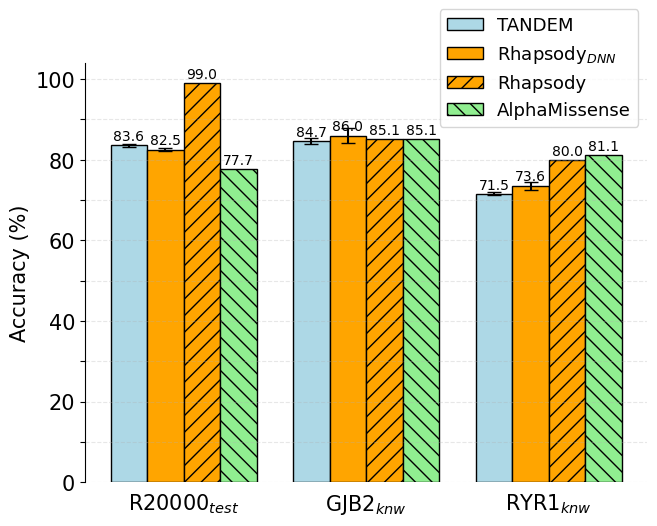

In [42]:
labels = ['TANDEM', r'Rhapsody$_{DNN}$', 'Rhapsody', 'AlphaMissense']
test_sets = [r'R20000$_{test}$', r'GJB2$_{knw}$', r'RYR1$_{knw}$']
colors = ['lightblue', 'orange', 'orange', 'lightgreen']
index = np.arange(len(labels))
interval = 0.2
width = 0.2
capsize = 5

params = {
    'capsize': 5,
    'width': 0.2,
    'edgecolor': 'black',
}

# Type of bar: // / or nothing
shape = ['', '', '//', '\\\\']
for i, entity in enumerate([tandem_R20000_test, rhapsodyDNN_R20000_test, [rhapsody_R20000_test], [AlphaMissense_R20000_test]]):
    mean_value = np.mean(entity)
    if i == 2 or i == 3:
        plt.bar(index[0] + i*interval, mean_value, color=colors[i], label=labels[i], hatch=shape[i], **params)
    else:
        plt.bar(index[0] + i*interval, mean_value, yerr=np.std(entity) / np.sqrt(len(entity)), color=colors[i], label=labels[i], hatch=shape[i], **params)
    plt.text(index[0] + i*interval, mean_value + 0.5, f'{mean_value:.1f}', ha='center', va='bottom', fontsize=10)

for i, entity in enumerate([tandem_GJB2, rhapsodyDNN_GJB2, [rhapsody_GJB2], [AlphaMissense_GJB2]]):
    if i == 2 or i == 3:
        plt.bar(index[1] + i*interval, np.mean(entity), color=colors[i], hatch=shape[i], **params)
    else:
        plt.bar(index[1] + i*interval, np.mean(entity), yerr=np.std(entity) / np.sqrt(len(entity)), color=colors[i], hatch=shape[i], **params)
    plt.text(index[1] + i*interval, np.mean(entity) + 0.5, f'{np.mean(entity):.1f}', ha='center', va='bottom', fontsize=10)

for i, entity in enumerate([tandem_RYR1, rhapsodyDNN_RYR1, [rhapsody_RYR1], [AlphaMissense_RYR1]]):
    if i == 2 or i == 3:
        plt.bar(index[2] + i*interval, np.mean(entity), color=colors[i], hatch=shape[i], **params)
    else:
        plt.bar(index[2] + i*interval, np.mean(entity), yerr=np.std(entity) / np.sqrt(len(entity)), color=colors[i], hatch=shape[i], **params)
    plt.text(index[2] + i*interval, np.mean(entity) + 0.5, f'{np.mean(entity):.1f}', ha='center', va='bottom', fontsize=10)

# Remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.tight_layout()

# Remove xticks, 
plt.xticks([0+0.3, 1+0.3, 2+0.3], test_sets, minor=False, fontsize=15)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
# plt.ylim(50, 100)
# y-ticks, each 10
plt.yticks(np.arange(0, 101, 10), fontsize=15)
plt.gca().set_yticklabels(['0', '', '20', '', '40', '', '60', '', '80', '', '100'])

# Grid
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.ylabel('Accuracy (%)', fontsize=15)
plt.legend(fontsize=13, loc='upper right', bbox_to_anchor=(1, 1.15))
plt.show()

In [39]:
# TANDEM on GJB2_test and on RYR1_test
tandem_GJB2_test = [100, 100, 80.0000011920929, 80.0000011920929, 100]
tandem_RYR1_test = [77.77777910232544, 77.77777910232544, 77.77777910232544, 77.77777910232544, 77.77777910232544]

# TANDEM_GJB2 on R20000_test and on GJB2_test
tandem_tfGJB2_R20000_test = [81.68, 82.97, 82.69, 82.92, 82.82]
tandem_tfGJB2_GJB2_test = [100.00, 100.00, 100.00, 100.00, 100.00]

tandem_tfRYR1_R20000_test = [79.62147196133932, 82.01990524927775, 82.23201036453247, 82.52569635709127, 82.01990524927775]
tandem_tfRYR1_RYR1_test = [92.59259303410848, 100, 100, 92.59259303410848, 100]

rhapsody_GJB2_test = 80
rhapsody_RYR1_test = 77.8
AlphaMissense_GJB2_test = 80
AlphaMissense_RYR1_test = 66.7

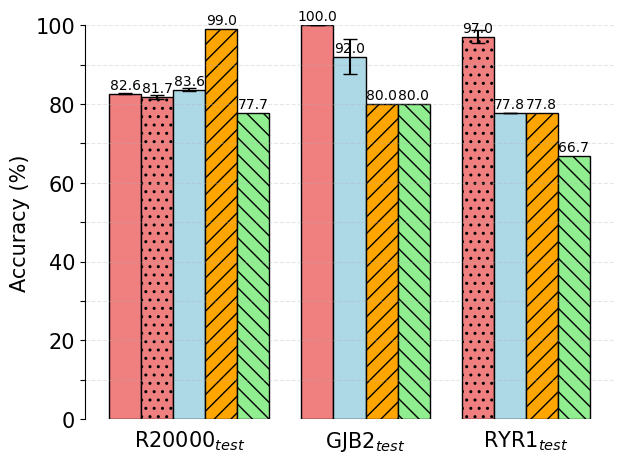

In [43]:

labels = ['Specific disease model', 'General disease model', 'Rhapsody', 'AlphaMissense']
labels = [r'TANDEM$_{GJB2}$', r'TANDEM$_{RYR1}$', 'TAMDEM']
test_sets = [r'R20000$_{test}$', r'GJB2$_{test}$', r'RYR1$_{test}$']
colors = ['lightblue', 'orange', 'orange', 'lightgreen']
index = np.arange(len(labels))
interval = 0.2
param = {
    'edgecolor': 'black',
    'capsize': 5,
    'width': 0.2
}
# Type of bar: // / or nothing
hatch = ['', '', '//', '//']

# R20000
plt.bar(0, np.mean(tandem_tfGJB2_R20000_test), yerr=np.std(tandem_tfGJB2_R20000_test) / np.sqrt(len(tandem_tfGJB2_R20000_test)), 
        color='lightcoral', label=r'TANDEM$_{GJB2}$', hatch='', **param)
plt.text(0, np.mean(tandem_tfGJB2_R20000_test) + 0.5, f'{np.mean(tandem_tfGJB2_R20000_test):.1f}', ha='center', va='bottom', fontsize=10)
plt.bar(0 + interval, np.mean(tandem_tfRYR1_R20000_test), yerr=np.std(tandem_tfRYR1_R20000_test) / np.sqrt(len(tandem_tfRYR1_R20000_test)),
        color='lightcoral', label=r'TANDEM$_{RYR1}$', hatch='..', **param)
plt.text(0 + interval, np.mean(tandem_tfRYR1_R20000_test) + 0.5, f'{np.mean(tandem_tfRYR1_R20000_test):.1f}', ha='center', va='bottom', fontsize=10)
plt.bar(0 + 2*interval, np.mean(tandem_R20000_test), yerr=np.std(tandem_R20000_test) / np.sqrt(len(tandem_R20000_test)),
        color='lightblue', hatch='', **param)
plt.text(0 + 2*interval, np.mean(tandem_R20000_test) + 0.5, f'{np.mean(tandem_R20000_test):.1f}', ha='center', va='bottom', fontsize=10)
# plt.bar(0 + 2*interval, np.mean(tandem_R20000_test), yerr=np.std(tandem_R20000_test) / np.sqrt(len(tandem_R20000_test)),
#         color='lightblue', label='TANDEM', hatch='', **param)
plt.bar(0 + 3*interval, rhapsody_R20000_test, color='orange', hatch='//', **param)
plt.text(0 + 3*interval, rhapsody_R20000_test + 0.5, f'{rhapsody_R20000_test:.1f}', ha='center', va='bottom', fontsize=10)
plt.bar(0 + 4*interval, AlphaMissense_R20000_test, color='lightgreen', hatch='\\\\', **param)
plt.text(0 + 4*interval, AlphaMissense_R20000_test + 0.5, f'{AlphaMissense_R20000_test:.1f}', ha='center', va='bottom', fontsize=10)

# GJB2_test
plt.bar(1.2, np.mean(tandem_tfGJB2_GJB2_test), yerr=np.std(tandem_tfGJB2_GJB2_test) / np.sqrt(len(tandem_tfGJB2_GJB2_test)),
        color='lightcoral', hatch='', **param)
plt.text(1.2, np.mean(tandem_tfGJB2_GJB2_test) + 0.5, f'{np.mean(tandem_tfGJB2_GJB2_test):.1f}', ha='center', va='bottom', fontsize=10)
plt.bar(1.2 + interval, np.mean(tandem_GJB2_test), yerr=np.std(tandem_GJB2_test) / np.sqrt(len(tandem_GJB2_test)),
        color='lightblue', hatch='', **param)
plt.text(1.2 + interval, np.mean(tandem_GJB2_test) + 0.5, f'{np.mean(tandem_GJB2_test):.1f}', ha='center', va='bottom', fontsize=10)
plt.bar(1.2 + 2*interval, rhapsody_GJB2_test, color='orange', hatch='//', **param)
plt.text(1.2 + 2*interval, rhapsody_GJB2_test + 0.5, f'{rhapsody_GJB2_test:.1f}', ha='center', va='bottom', fontsize=10)
plt.bar(1.2 + 3*interval, AlphaMissense_GJB2_test, color='lightgreen', hatch='\\\\', **param)
plt.text(1.2 + 3*interval, AlphaMissense_GJB2_test + 0.5, f'{AlphaMissense_GJB2_test:.1f}', ha='center', va='bottom', fontsize=10)

# RYR1_test
plt.bar(2.2, np.mean(tandem_tfRYR1_RYR1_test), yerr=np.std(tandem_tfRYR1_RYR1_test) / np.sqrt(len(tandem_tfRYR1_RYR1_test)),
        color='lightcoral', hatch='..', **param)
plt.text(2.2, np.mean(tandem_tfRYR1_RYR1_test) + 0.5, f'{np.mean(tandem_tfRYR1_RYR1_test):.1f}', ha='center', va='bottom', fontsize=10)
plt.bar(2.2 + interval, np.mean(tandem_RYR1_test), yerr=np.std(tandem_RYR1_test) / np.sqrt(len(tandem_RYR1_test)),
        color='lightblue', hatch='', **param)
plt.text(2.2 + interval, np.mean(tandem_RYR1_test) + 0.5, f'{np.mean(tandem_RYR1_test):.1f}', ha='center', va='bottom', fontsize=10)
plt.bar(2.2 + 2*interval, rhapsody_RYR1_test, color='orange', hatch='//', **param)
plt.text(2.2 + 2*interval, rhapsody_RYR1_test + 0.5, f'{rhapsody_RYR1_test:.1f}', ha='center', va='bottom', fontsize=10)
plt.bar(2.2 + 3*interval, AlphaMissense_RYR1_test, color='lightgreen', hatch='\\\\', **param)
plt.text(2.2 + 3*interval, AlphaMissense_RYR1_test + 0.5, f'{AlphaMissense_RYR1_test:.1f}', ha='center', va='bottom', fontsize=10)

# plt.bar(2.2 + 2*interval, rhapsody_RYR1_test, color='orange', label='Rhapsody' ,hatch='//', **param)
# plt.bar(2.2 + 3*interval, AlphaMissense_RYR1_test, color='lightgreen', label='AlphaMissense', hatch='\\\\', **param)



# Remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.tight_layout()

# Remove xticks, 
plt.xticks([0+0.4, 1+0.5, 2+0.5], test_sets, minor=False, fontsize=15)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
plt.ylim(0, 100)
# plt.xlim(-1,)

plt.yticks(np.arange(0, 101, 10), fontsize=15)
plt.gca().set_yticklabels(['0', '', '20', '', '40', '', '60', '', '80', '', '100'])

# Grid
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.ylabel('Accuracy (%)', fontsize=15)
# plt.legend(fontsize=12, loc='upper right')
# plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1, 2))
plt.tight_layout()
plt.show()